# Hands-On NLP — Class 1

<span style="color:magenta">Group members:</span>

* Petko Petkov

## Outline

- Getting some data

- Understanding a text corpus

  - Unicode

  - Character distributions

- The notion of words

  - Word distributions

  - Types and tokens

  - Text complexity

## pre-requisites

In [ ]:
# if you want to create a virtual environment "honlp" and install the necessary packages, you can use the following command:
# !python3 -m venv honlp && source honlp/bin/activate && pip install ipykernel pandas jinja2 seaborn scikit-learn nltk ipywidgets tqdm bs4 lxml py7zr jsonlines zstandard ujson requests wget lm-dataformat && python -m ipykernel install --user --name=honlp --quiet


In [ ]:
# if you've chosen your own environment, you can use the following command to install the necessary packages:
# !pip install ipykernel pandas jinja2 seaborn scikit-learn nltk ipywidgets tqdm bs4 lxml py7zr jsonlines zstandard ujson requests wget lm-dataformat
!pip check

In [1]:
import re, unicodedata, nltk, os, requests, zipfile # if error here, restart the kernel and run this cell again
from collections import Counter
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm


In [2]:
tqdm.pandas()
nltk.download("punkt")
nltk.download('punkt_tab')
sns.set_style("darkgrid")
sns.set_context("notebook")
pd.set_option('display.precision', 2)

[nltk_data] Downloading package punkt to /home/petko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/petko/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# Getting some data

- If you have already downloaded the preprocessed "texts" folder, skip this, if not uncomment

- If you don't know how to use *git*, *conda* or *pip* inside of the notebook, learn it *now*

#### 🚧 TODO: Fix the code in the cloned git repository and get it running:

In [3]:
# !git clone https://github.com/EleutherAI/stackexchange_dataset/

# 🚧 go into the directory and modify downloader.py: 
# change the download URL from https://ia600107.us.archive.org/27/items/stackexchange/Sites.xml 
# to https://ia800506.us.archive.org/8/items/stack-exchange-data-dump-2023-09-12/Sites.xml

In [4]:
# then download the data. only once because it's slow (~10 minutes) mythology.stackexchange,
# this function will download the data, extract it, and propose a zip file inside of the "out" folder
# !python stackexchange_dataset/main.py --names mythology.stackexchange,woodworking.stackexchange,robotics.stackexchange,hsm.stackexchange,health.stackexchange,portuguese.stackexchange

In [3]:
# Base directory for output ZIPs and destination for texts
ZIP_DIR = "out"
TEXTS_DIR = "texts"

# Create the base texts directory if it doesn't exist
os.makedirs(TEXTS_DIR, exist_ok=True)

def extract_zip_to_folder(zip_path, extract_to):
    """Extract all text files from a ZIP archive to a specific folder."""
    try:
        print(f"Extracting {zip_path} to {extract_to}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Extracted to {extract_to}")
    except zipfile.BadZipFile as e:
        print(f"Failed to extract {zip_path}: {e}")


CORPORA = [
    "mythology",
    "woodworking",
    "robotics",
    "hsm",
    "health",
    "portuguese",
]

# Process each corpus
for corpus in CORPORA:
    zip_path = Path(ZIP_DIR) / f"{corpus}.stackexchange.zip"
    output_folder = Path(TEXTS_DIR) / corpus
    output_folder.mkdir(parents=True, exist_ok=True)
    
    if zip_path.exists():
        extract_zip_to_folder(zip_path, output_folder)
    else:
        print(f"ZIP file {zip_path} does not exist.")


Extracting out/mythology.stackexchange.zip to texts/mythology...
Extracted to texts/mythology
Extracting out/woodworking.stackexchange.zip to texts/woodworking...
Extracted to texts/woodworking
Extracting out/robotics.stackexchange.zip to texts/robotics...
Extracted to texts/robotics
Extracting out/hsm.stackexchange.zip to texts/hsm...
Extracted to texts/hsm
Extracting out/health.stackexchange.zip to texts/health...
Extracted to texts/health
Extracting out/portuguese.stackexchange.zip to texts/portuguese...
Extracted to texts/portuguese


### a first dataframe

In [4]:
corpora = {}
stats = []

for corpus in tqdm(CORPORA):
    print(corpus)
    texts = []
    for fp in (Path(TEXTS_DIR) / corpus).glob("*.txt"):
        with fp.open() as f:
            texts.append(f.read())

    corpora[corpus] = "\n".join(texts)

    stats.append(
        {
            "corpus": corpus,
            "files_n": len(texts),
            "chars_n": len(corpora[corpus]),
        }
    )

df = pd.DataFrame.from_records(stats, index=["corpus"])
df["text"] = [corpora[corpus] for corpus in corpora]
df

  0%|          | 0/6 [00:00<?, ?it/s]

mythology
woodworking
robotics
hsm
health
portuguese


,files_n,chars_n,text
corpus,,,
mythology,1503,4969844,Q:\n\nWhy were the Greek Gods on Olympus?\n\nI...
woodworking,2860,7842345,Q:\n\nIs support on three sides of a long popl...
robotics,39674,110916720,Q:\n\nErrors compiling Rosjava code\n\nI am ha...
hsm,2887,9469026,Q:\n\nAnalysis vs Synthesis in Greek Mathemati...
health,3733,10217955,Q:\n\nCan Sour/Acidic Food reduce libido in me...
portuguese,2026,4829592,Q:\n\nTradução de “full volume”\n\nEm inglês t...


In [7]:
for corpus, text in corpora.items():
    print(f"*** {corpus} ***")
    print(text[:65])

*** mythology ***
Q:

Why were the Greek Gods on Olympus?

It's a well known fact t
*** woodworking ***
Q:

Is support on three sides of a long poplar bookshelf enough?

*** robotics ***
Q:

Errors compiling Rosjava code

I am having a compiler issue w
*** hsm ***
Q:

Analysis vs Synthesis in Greek Mathematics

I am trying to un
*** health ***
Q:

Can Sour/Acidic Food reduce libido in men?

I live in Asia wh
*** portuguese ***
Q:

Tradução de “full volume”

Em inglês tem uma expressão “music


# Visualizing the corpus

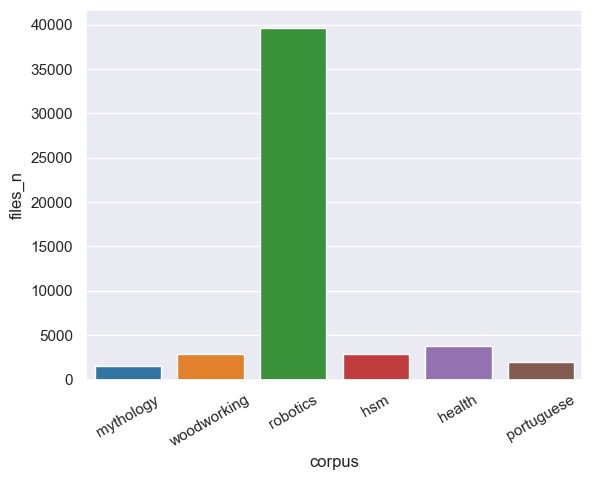

In [5]:
sns.barplot(x=df.index, y="files_n", data=df, hue="corpus")
plt.xticks(rotation=30)
plt.show()

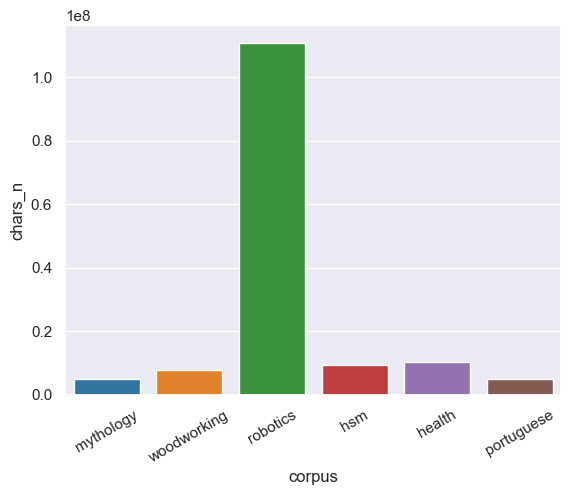

In [6]:
sns.barplot(x=df.index, y="chars_n", data=df, hue="corpus")
plt.xticks(rotation=30)
plt.show()

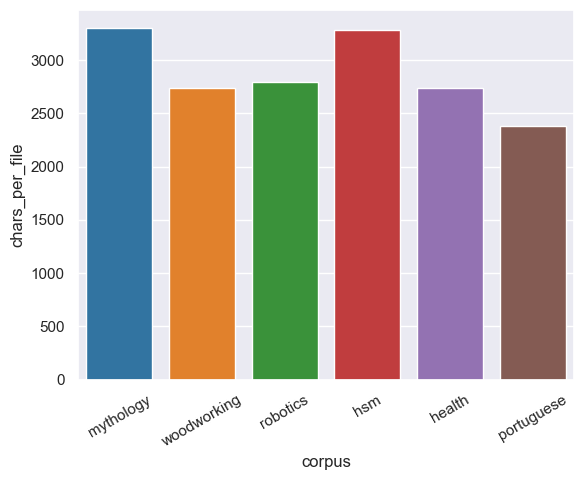

In [7]:
df["chars_per_file"] = df.chars_n / df.files_n
sns.barplot(x=df.index, y="chars_per_file", data=df, hue="corpus")
plt.xticks(rotation=30)
plt.show()

In [8]:
char_counters = df.text.map(Counter)

print(char_counters.health)

Counter({' ': 1592446, 'e': 961981, 't': 706632, 'a': 631545, 'i': 609864, 'o': 606200, 'n': 554525, 's': 540158, 'r': 473275, 'h': 333197, 'l': 329916, 'c': 287748, 'd': 284226, 'u': 232413, 'm': 202239, 'f': 173463, 'p': 165828, 'y': 150628, 'g': 146077, 'b': 112885, '\n': 112102, 'w': 106463, '.': 93473, 'v': 90403, ',': 81969, 'k': 46176, 'I': 34341, '-': 27757, 'A': 26104, 'T': 24914, '0': 24248, ':': 23506, '1': 22732, ')': 22534, '(': 22187, 'x': 20815, '2': 18134, 'S': 18067, '/': 17431, 'C': 17333, "'": 15544, 'D': 13577, '?': 11665, 'H': 11121, '"': 11046, 'M': 11022, 'P': 11016, 'R': 9371, '3': 9088, '5': 8781, 'q': 8740, '9': 8372, 'B': 8239, 'W': 8199, 'O': 8173, 'E': 7944, 'N': 7781, 'F': 7585, 'z': 7082, '4': 6911, 'j': 6884, '6': 6186, '8': 5669, 'V': 5645, '7': 5547, 'L': 5376, 'G': 4298, 'Q': 4284, 'U': 3774, '%': 3463, ';': 2868, 'J': 2769, 'Y': 2517, 'K': 2024, ']': 1706, '[': 1703, '=': 1269, '’': 1266, '–': 1249, '_': 1076, '&': 1056, '“': 791, '”': 769, '+': 722,

In [9]:
df["char_types_n"] = char_counters.map(len)
df

,files_n,chars_n,text,chars_per_file,char_types_n
corpus,,,,,
mythology,1503,4969844,Q:\n\nWhy were the Greek Gods on Olympus?\n\nI...,3306.62,1702
woodworking,2860,7842345,Q:\n\nIs support on three sides of a long popl...,2742.08,173
robotics,39674,110916720,Q:\n\nErrors compiling Rosjava code\n\nI am ha...,2795.70,1183
hsm,2887,9469026,Q:\n\nAnalysis vs Synthesis in Greek Mathemati...,3279.88,697
health,3733,10217955,Q:\n\nCan Sour/Acidic Food reduce libido in me...,2737.20,335
portuguese,2026,4829592,Q:\n\nTradução de “full volume”\n\nEm inglês t...,2383.81,458


### Note the presence of non-ascii characters
some may not show up correctly in the notebook
- space 
  - '\u200c' '\u200e' '\u3000' '\xa0' ???
- other letters
  - diacritics: ĕ Ł 
- other characters
  - other languages 茶 Ꝣ  ी が
  - symbols €
  - graphical symbols ■
  - emoji ✅ 🤗
- punctuation
  - , ! ≫ '\xad'


In [10]:
# new in 2021: ⃀ (Kyrgyzstani som)
#   (see also https://www.unicode.org/emoji/charts-14.0/emoji-released.html)

for ch in "ĕŁ茶Ꝣीが€,!≫■✅🤗\u200c\u200e\u3000\xa0\xad":
    print(unicodedata.category(ch), ":::", unicodedata.name(ch))

Ll ::: LATIN SMALL LETTER E WITH BREVE
Lu ::: LATIN CAPITAL LETTER L WITH STROKE
Lo ::: CJK UNIFIED IDEOGRAPH-8336
Lu ::: LATIN CAPITAL LETTER VISIGOTHIC Z
Mc ::: DEVANAGARI VOWEL SIGN II
Lo ::: HIRAGANA LETTER GA
Sc ::: EURO SIGN
Po ::: COMMA
Po ::: EXCLAMATION MARK
Sm ::: MUCH GREATER-THAN
So ::: BLACK SQUARE
So ::: WHITE HEAVY CHECK MARK
So ::: HUGGING FACE
Cf ::: ZERO WIDTH NON-JOINER
Cf ::: LEFT-TO-RIGHT MARK
Zs ::: IDEOGRAPHIC SPACE
Zs ::: NO-BREAK SPACE
Cf ::: SOFT HYPHEN


In [11]:
myth_char_freq_df = pd.DataFrame.from_dict(
    char_counters.mythology, orient="index", columns=["freq"]
)
myth_char_freq_df.sort_values("freq", inplace=True, ascending=False)
myth_char_freq_df.index.name = "char"
myth_char_freq_df

,freq
char,
,828995
e,474636
t,330969
a,305082
o,289995
...,...
録,1
撰,1
基,1


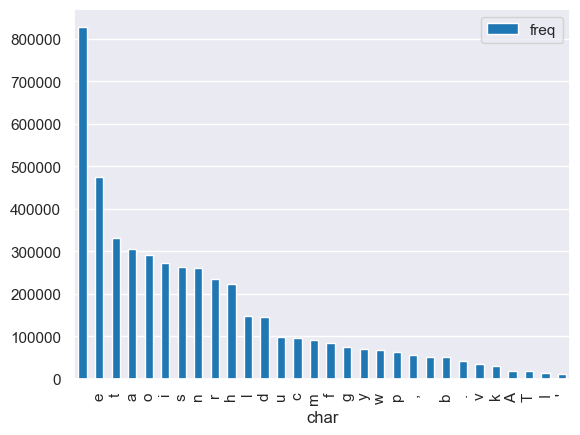

In [12]:
myth_char_freq_df.head(30).plot(kind="bar")
plt.grid(axis="x")
plt.show()

Note that seaborn can do the same thing (arguably looks fancier)

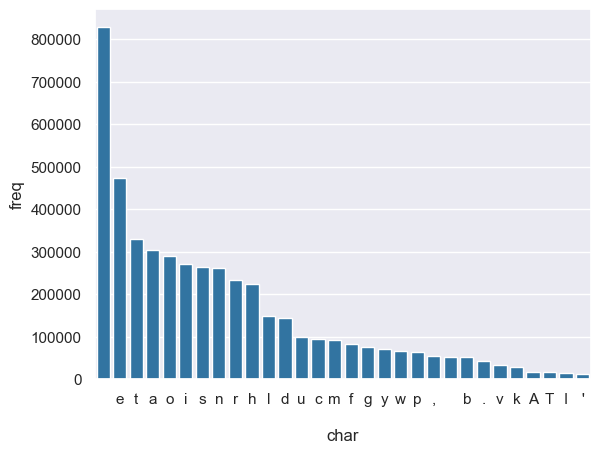

In [13]:
sns.barplot(
    x=myth_char_freq_df.head(30).index,
    y="freq",
    data=myth_char_freq_df.head(30),
)
plt.show()

/home/petko/uni/t_3/HoNLP/m1-hands-on-NLP/honlp/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 23736 (\N{CJK UNIFIED IDEOGRAPH-5CB8}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


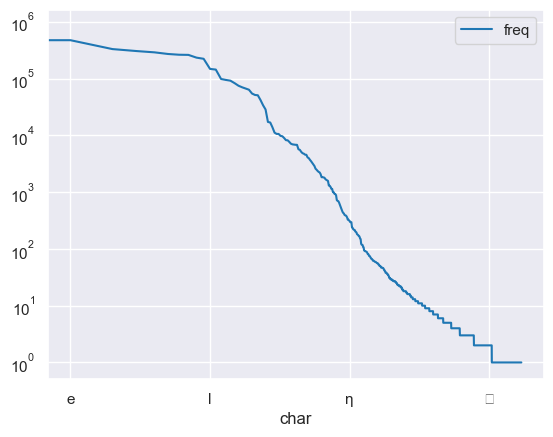

In [14]:
myth_char_freq_df.plot(loglog=True)
plt.show()

In [15]:
df

,files_n,chars_n,text,chars_per_file,char_types_n
corpus,,,,,
mythology,1503,4969844,Q:\n\nWhy were the Greek Gods on Olympus?\n\nI...,3306.62,1702
woodworking,2860,7842345,Q:\n\nIs support on three sides of a long popl...,2742.08,173
robotics,39674,110916720,Q:\n\nErrors compiling Rosjava code\n\nI am ha...,2795.70,1183
hsm,2887,9469026,Q:\n\nAnalysis vs Synthesis in Greek Mathemati...,3279.88,697
health,3733,10217955,Q:\n\nCan Sour/Acidic Food reduce libido in me...,2737.20,335
portuguese,2026,4829592,Q:\n\nTradução de “full volume”\n\nEm inglês t...,2383.81,458


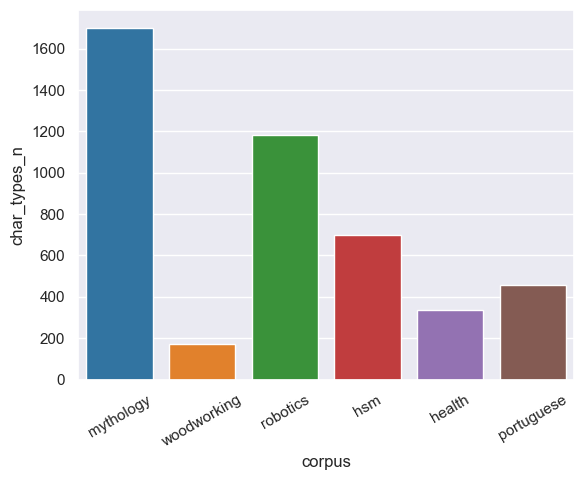

In [16]:
sns.barplot(x=df.index, y="char_types_n", data=df, hue="corpus")
plt.xticks(rotation=30)
plt.show()

#### How to compute richness in characters?

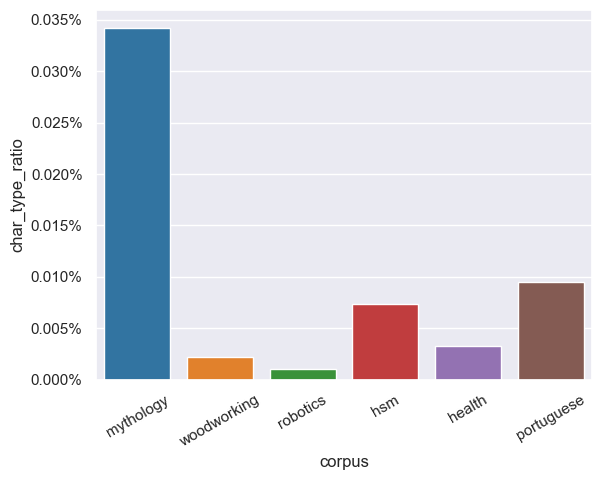

In [17]:
df["char_type_ratio"] = df.char_types_n / df.chars_n
ax = sns.barplot(x=df.index, y="char_type_ratio", data=df, hue="corpus")
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1, decimals=3))
plt.xticks(rotation=30)
plt.show()

In [18]:
char_counters = df.text.map(lambda x: Counter(x[:1000]))
print(char_counters.health)
df["type_chars_1000"] = char_counters.map(len)

Counter({' ': 174, 'e': 95, 't': 69, 'a': 66, 'i': 63, 'n': 54, 'o': 49, 's': 46, 'r': 42, 'd': 40, 'h': 35, 'c': 26, 'u': 22, 'y': 20, '\n': 19, 'l': 19, 'm': 17, 'v': 15, 'g': 13, 'b': 12, 'f': 12, 'w': 10, 'p': 9, 'I': 7, 'k': 7, '.': 6, '"': 6, 'A': 5, '?': 5, ':': 4, ',': 4, 'E': 4, 'D': 3, 'Q': 2, 'S': 2, '/': 2, 'F': 2, '(': 2, ')': 2, 'T': 2, 'P': 2, 'H': 2, "'": 2, 'C': 1, 'q': 1})


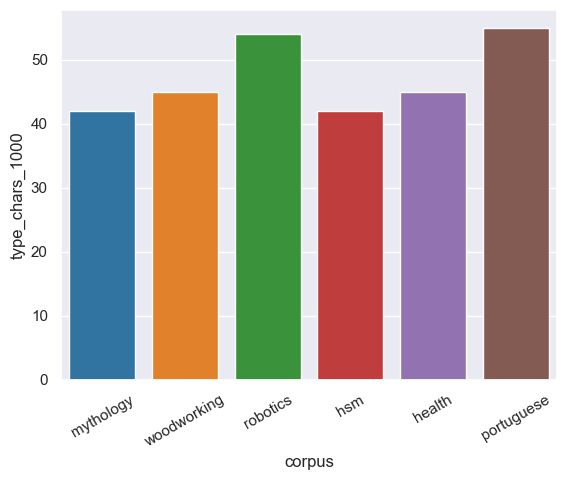

In [19]:
sns.barplot(x=df.index, y="type_chars_1000", data=df, hue="corpus")
plt.xticks(rotation=30)
plt.show()

### What's going on here? Which text is the richest in characters?

In [20]:
HOP = 100_000

In [21]:
def batch_counts(text, max_len, hop):
    counters = [Counter()]
    for i in range(hop, max_len, hop):
        counters.append(counters[-1] + Counter(text[i - hop : i]))
    return [len(cntr) for cntr in counters]

In [22]:
df.head(2)

,files_n,chars_n,text,chars_per_file,char_types_n,char_type_ratio,type_chars_1000
corpus,,,,,,,
mythology,1503,4969844,Q:\n\nWhy were the Greek Gods on Olympus?\n\nI...,3306.62,1702,3.42e-04,42
woodworking,2860,7842345,Q:\n\nIs support on three sides of a long popl...,2742.08,173,2.21e-05,45


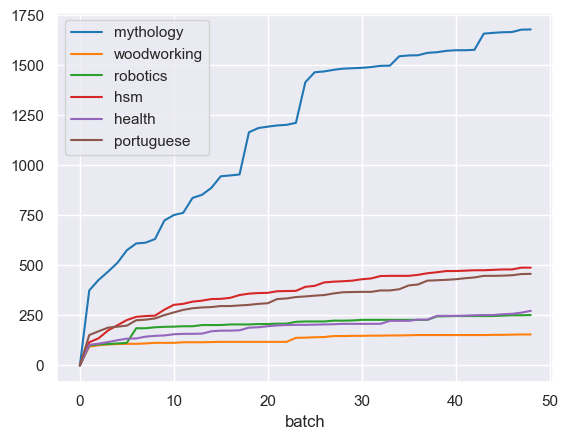

In [23]:
batch_counters = df.text.map(
    lambda x: batch_counts(x, max_len=df.chars_n.min(), hop=HOP)
)

batch_counters_df = pd.DataFrame(
    dict(zip(batch_counters.index, batch_counters.values))
)
batch_counters_df.index.name = "batch"

batch_counters_df.plot()
plt.show()

- Zooming in:

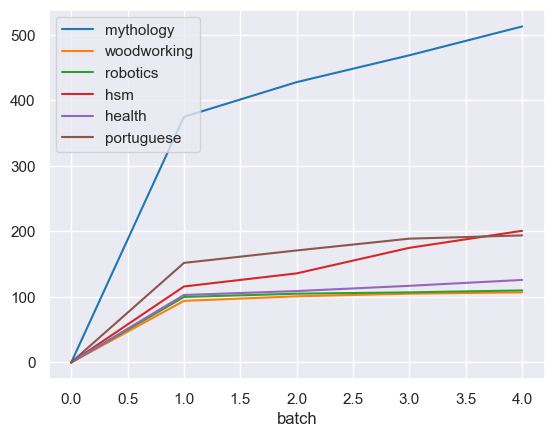

In [24]:
batch_counters_df.head(5).plot()
plt.show()

### What's happening here?
#### 🚧 TODO:

For mythology the vocabulary grows very quickly in the first batch and continues to grow steadily across the batches. This means the corpus is rich in unique characters, maybe because of the variety in names, terms, and symbols associated with mythology.

The other topics show slower vocabulary growth compared to mythology. This suggests they are more specialized and likely use a smaller, more consistent set of characters in their text.

___



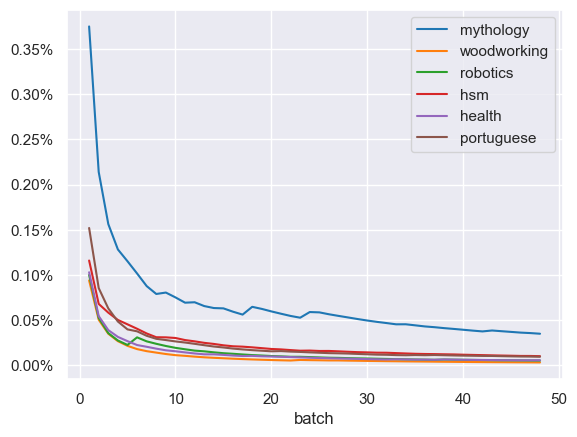

In [25]:
batches = np.arange(0, df.chars_n.min(), HOP)
batch_counters_freq_df = batch_counters_df.divide(batches, axis="index")
ax = batch_counters_freq_df.plot()
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1, decimals=2))
plt.show()

- We see three levels on which these lines seem to stabilize: 
  
  - mythology
  
  - portoguese and hsm
  
  - robotics, health, and woodworking

---

# Tokens and words

### Tokenizing

In [26]:
text = "Wait—what?!! You won't believe this: cats, dogs, & raccoons... ALL playing chess at 3:00 a.m.?! #unreal2025"
token_splits = text.split()

print("|".join(token_splits))
len(token_splits)


Wait—what?!!|You|won't|believe|this:|cats,|dogs,|&|raccoons...|ALL|playing|chess|at|3:00|a.m.?!|#unreal2025


16

In [27]:
chars_re = re.compile(r"\W+")
token_splits = chars_re.split(text)

print("|".join(token_splits))
len(token_splits)

Wait|what|You|won|t|believe|this|cats|dogs|raccoons|ALL|playing|chess|at|3|00|a|m|unreal2025


19

In [28]:
char_or_hyphen_re = re.compile(r"[\w-]+")
token_splits = char_or_hyphen_re.findall(text)

print("|".join(token_splits))
len(token_splits)

Wait|what|You|won|t|believe|this|cats|dogs|raccoons|ALL|playing|chess|at|3|00|a|m|unreal2025


19

Idiosyncratic rules for English!

- Think of *viens-tu*, *où va-text-il*, *Kaffeetasse*, *cantolo*, *我爱你*, ...

- Can you think of other cases in your language where the tokenizer does not work? What does the tokenizer do?

### Using a specialized class: `nltk`

In [29]:

nltk_tokens = word_tokenize(text)

print("|".join(nltk_tokens))
len(nltk_tokens)

Wait—what|?|!|!|You|wo|n't|believe|this|:|cats|,|dogs|,|&|raccoons|...|ALL|playing|chess|at|3:00|a.m.|?|!|#|unreal2025


27

### Not bad. Does it work for Portuguese?

In [30]:
print(corpora["portuguese"][:333])

pt_tokens = word_tokenize(corpora["portuguese"][:333])
print("|".join(pt_tokens))
print(len(pt_tokens))

Q:

Tradução de “full volume”

Em inglês tem uma expressão “music at full volume” e eu quero saber como traduzi-la em português.

A:

O mais comum seria "volume máximo".
"Estava ele a ouvir música no volume máximo."
Exemplos da web:s

"música eletrônica para ouvir no volume máximo
Eu sempre colocava músicas para tocar e, frequentem
Q|:|Tradução|de|“|full|volume|”|Em|inglês|tem|uma|expressão|“|music|at|full|volume|”|e|eu|quero|saber|como|traduzi-la|em|português|.|A|:|O|mais|comum|seria|``|volume|máximo|''|.|``|Estava|ele|a|ouvir|música|no|volume|máximo|.|''|Exemplos|da|web|:|s|''|música|eletrônica|para|ouvir|no|volume|máximo|Eu|sempre|colocava|músicas|para|tocar|e|,|frequentem
72


Watch out: 
- da = de + a, do = de + o
("of the" or "from the" in English)

- pelas = por + as, pelo = por + o
("through the" or "by the" in English)

In [31]:
toks = [
    word_tokenize(text[:1_000_000]) for corpus, text in tqdm(corpora.items())
]

  0%|          | 0/6 [00:00<?, ?it/s]

So be patient for this line:

In [32]:
# If your machine is slow, pickeling allows to go faster next time.
# On our machines it takes about 40 seconds

DATA = Path("data")
DATA.mkdir(exist_ok=True)

tokens_fp = DATA / "tokens.pkl"
try:
    tokens = pd.read_pickle(tokens_fp)
except FileNotFoundError:
    tokens = df.text.progress_map(word_tokenize)
    tokens.to_pickle(tokens_fp)

In [33]:
df["tokens"] = tokens
df["tokens_n"] = df.tokens.map(len)
df["types_n"] = df.tokens.map(set).map(len)
df.head(2)

,files_n,chars_n,text,chars_per_file,char_types_n,char_type_ratio,type_chars_1000,tokens,tokens_n,types_n
corpus,,,,,,,,,,
mythology,1503,4969844,Q:\n\nWhy were the Greek Gods on Olympus?\n\nI...,3306.62,1702,3.42e-04,42,"[Q, :, Why, were, the, Greek, Gods, on, Olympu...",998926,53030
woodworking,2860,7842345,Q:\n\nIs support on three sides of a long popl...,2742.08,173,2.21e-05,45,"[Q, :, Is, support, on, three, sides, of, a, l...",1620394,35469


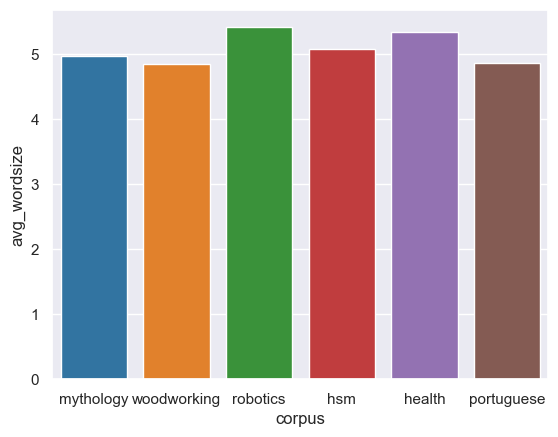

In [34]:
df["avg_wordsize"] = df.chars_n / df.tokens_n
sns.barplot(x=df.index, y="avg_wordsize", data=df, hue="corpus")
plt.show()

In [35]:
word_ctr = Counter(df.tokens.mythology)
myth_tok_freq_df = pd.DataFrame.from_dict(
    word_ctr, orient="index", columns=["freq"]
)
myth_tok_freq_df.sort_values("freq", inplace=True, ascending=False)
myth_tok_freq_df.index.name = "token"
myth_tok_freq_df.head()

,freq
token,
",",54420
the,54068
.,34984
of,31362
and,22209


In [36]:
word_ctr = Counter(df.tokens.woodworking)
wood_tok_freq_df = pd.DataFrame.from_dict(
    word_ctr, orient="index", columns=["freq"]
)
wood_tok_freq_df.sort_values("freq", inplace=True, ascending=False)
wood_tok_freq_df.index.name = "token"
wood_tok_freq_df.head()

,freq
token,
the,76380
.,60449
",",48519
to,45067
a,42519


### Frequency of word length

#### 🚧 TODO

- Give the average length of tokens per corpus — clearly define what average you measure!

- Give the longest word per corpus and give their length

**Note:**

- We can compute the average length over tokens or types. As frequent words are shorter, we expect the average length over tokens to be smaller than over types.

In [37]:
# Seperate functions that can be reused for each text:

def avg_len_tokens(toks):
    return sum(len(t) for t in toks) / len(toks)

def max_len_tokens(toks):
    return max(len(t) for t in toks)

def longest_words(toks):
    max_len = max_len_tokens(toks)
    return [t for t in toks if len(t) == max_len]

def avg_len_types(types):
    unique_types = set(types)  # convert to a set to get unique types
    return sum(len(t) for t in unique_types) / len(unique_types)

In [38]:
print("\n*** average length in the dictionary (on types) ***")
display(tokens.map(avg_len_types))

print("\n*** average length in the text (on tokens) ***")
display(tokens.map(avg_len_tokens))


*** average length in the dictionary (on types) ***


corpus
mythology       7.73
woodworking     8.35
robotics       19.29
hsm             8.37
health         10.04
portuguese      8.00
Name: text, dtype: float64


*** average length in the text (on tokens) ***


corpus
mythology      4.10
woodworking    3.94
robotics       4.51
hsm            4.24
health         4.45
portuguese     4.04
Name: text, dtype: float64

In [39]:
print("\n*** the longest words' length ***")
display(tokens.map(max_len_tokens))

print("\n*** the longest words ***")
display(tokens.map(longest_words))


*** the longest words' length ***


corpus
mythology       305
woodworking     143
robotics       1578
hsm             182
health          265
portuguese      125
Name: text, dtype: int64


*** the longest words ***


corpus
mythology      [亮乃北行見備，備與亮非舊，又以其年少，以諸生意待之。坐集既畢，眾賓皆去，而亮獨留，備亦不問...
woodworking    [//www.homedepot.com/p/Hampton-Bay-6-ft-L-x-39...
robotics       [000000ff00000000fd00000004000000000000016a000...
hsm            [//www.quora.com/Why-did-Einstein-write-Since-...
health         [//www.researchgate.net/profile/Secil_Vural/pu...
portuguese     [//educacao.uol.com.br/disciplinas/cultura-bra...
Name: text, dtype: object

#### We can try to remove all non-ascii characters to get to actual long words

In [40]:
wood_tok_freq_df["len"] = wood_tok_freq_df.index.str.len()
wood_tok_filtered_df = wood_tok_freq_df[
    ~wood_tok_freq_df.index.str.contains(r"[0-9/=+\._-]")
]
wood_tok_filtered_df.sort_values(by="len", ascending=False).head(10)

,freq,len
token,,
halfdovetaillapjoints,1,21
GraphussupportsMonica,1,21
CrazyRussianWoodShop,1,20
uncharacteristically,1,20
AloysiusDefenestrate,3,20
CanadianWoodworking,1,19
curiouslysatisfying,1,19
characteristically,1,18
GreatPlanesTrading,1,18


- Yay! we found "disproportionately"!
- you could also do smarter things to be use not to have forgotten any word in non-ascii characters (not mandatory)

#### 🚧 TODO: Let's process all corpora to get their word length distribution

In [41]:
def len_freq_counter(text):
    return Counter(len(token) for token in text)

df['len_freq'] = df['tokens'].map(len_freq_counter)

len_freq_dict = {corpus: freq for corpus, freq in zip(df.index, df['len_freq'])}
len_freq_df = pd.DataFrame(len_freq_dict).fillna(0).astype(int)
len_freq_df = len_freq_df.sort_index()
len_freq_df = df['len_freq'].apply(pd.Series).fillna(0) # replace NaN with 0
len_freq_df = len_freq_df.T
len_freq_df.index.name = 'length'

In [42]:
len_freq_df

corpus,mythology,woodworking,robotics,hsm,health,portuguese
length,,,,,,
1,162566.0,248312.0,5.32e+06,357867.0,322828.0,254639.0
3,176327.0,299145.0,2.70e+06,282710.0,286207.0,120565.0
4,141993.0,279062.0,2.44e+06,222336.0,262830.0,89304.0
5,99864.0,171534.0,1.62e+06,155005.0,171104.0,87970.0
2,163488.0,267055.0,3.02e+06,317364.0,300980.0,160488.0
...,...,...,...,...,...,...
231,0.0,0.0,0.00e+00,0.0,1.0,0.0
265,0.0,0.0,0.00e+00,0.0,1.0,0.0
204,0.0,0.0,0.00e+00,0.0,1.0,0.0


- Note: There is quite a few NaN!

#### Let's plot the mythology word length distribution

In [43]:
myth_len_freqs = len_freq_df.mythology.sort_values(ascending=False)
myth_len_freqs.head(5)

length
3    176327.0
2    163488.0
1    162566.0
4    141993.0
5     99864.0
Name: mythology, dtype: float64

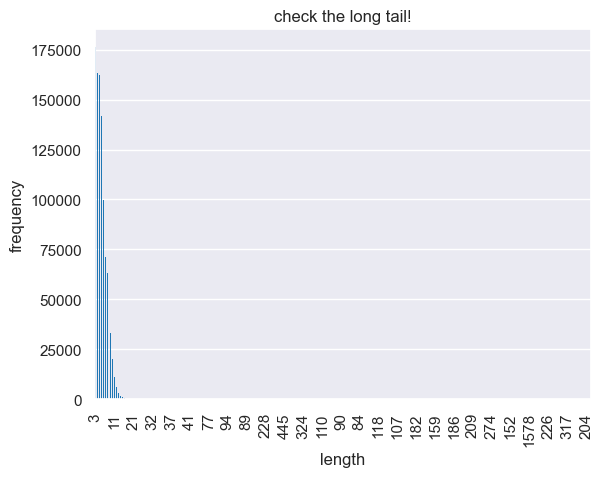

In [44]:
ax = myth_len_freqs.plot.bar(title="check the long tail!", linewidth=0)

# Print only 1 x-tick-label out of 10
for i, label in enumerate(ax.get_xticklabels()):
    if (i % 10) != 0:
        label.set_visible(False)

plt.ylabel("frequency")
plt.grid(axis="x")
plt.show()

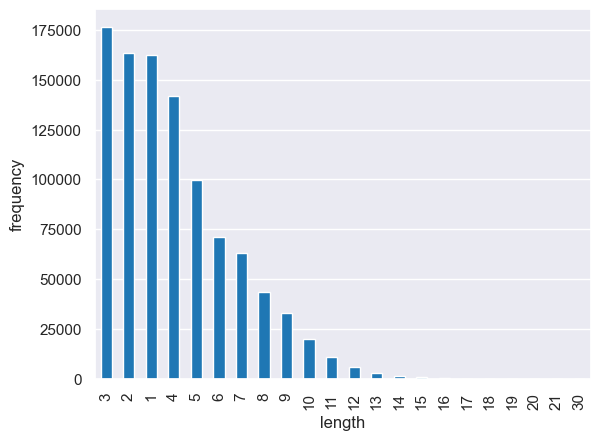

length
3    176327.0
2    163488.0
1    162566.0
4    141993.0
5     99864.0
Name: mythology, dtype: float64

In [45]:
myth_len_freqs.head(22).plot.bar()
plt.ylabel("frequency")
plt.grid(axis="x")
plt.show()

myth_len_freqs.head(5)

- If you order by token length you get a nice distribution shape, something close to the hypergeometric distribution.
### 🚧 TODO: explain this graph:

Shorter lengths (1-5) have very high frequencies, with some reaching over 150,000 occurrences.

There's a sharp decline in frequency as the length increases.

Lengths beyond 10 have relatively low frequencies, mostly below 25,000.

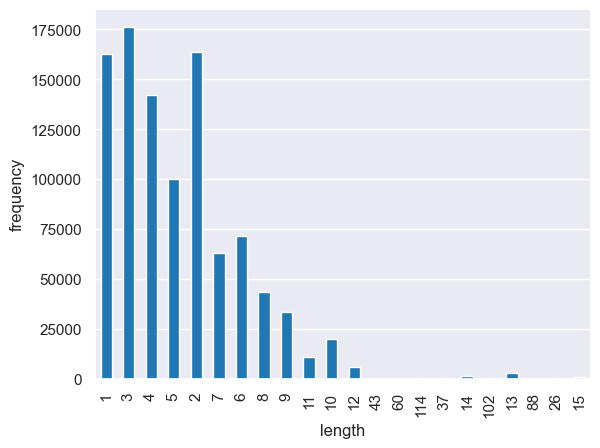

In [46]:
len_freq_df.mythology.head(22).plot.bar()
plt.ylabel("frequency")
plt.grid(axis="x")
plt.show()

# 💥 Let's Zipf token frequencies!

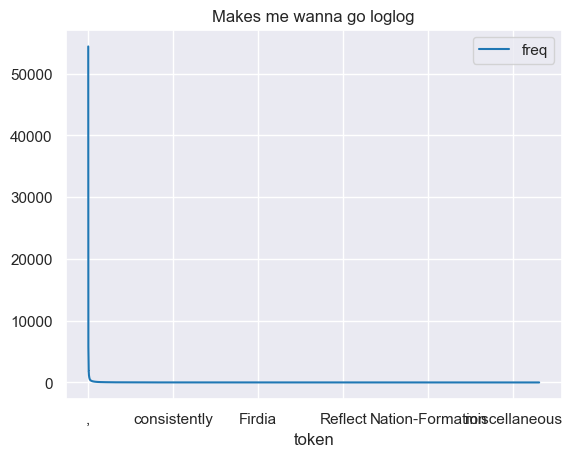

In [47]:
myth_tok_freq_df.plot(title="Makes me wanna go loglog")
plt.show()

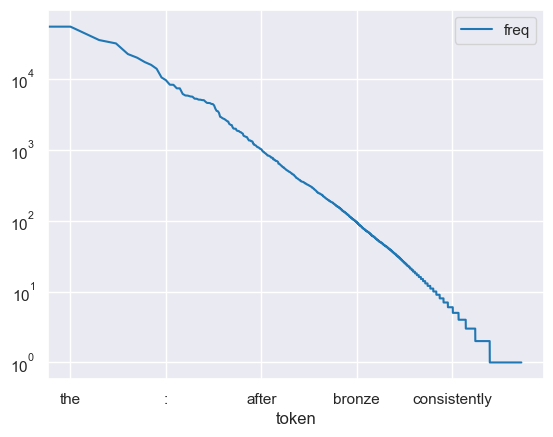

In [48]:
myth_tok_freq_df.plot(loglog=True)
plt.show()

### Wow! How straight is that!

- Explain why there are: `,: after fear Z?` (on the x-axis, if everything works well)

#### 🚧 TODO: Now let's process the token freq for every corpus

In [61]:
token_freq_dfs = {}
for corpus in df.index:
    # get token counts
    word_ctr = Counter(df.tokens[corpus])
    
    # convert to df and sort by frequency
    freq_df = pd.DataFrame.from_dict(word_ctr, orient='index', columns=['freq'])
    freq_df.sort_values('freq', inplace=True, ascending=False)
    token_freq_dfs[corpus] = freq_df['freq']

# combine all frequencies into one df
all_token_freqs_df = pd.DataFrame(token_freq_dfs)

# sort by descending frequency
all_token_freqs_df.sort_values(by=df.index.tolist(), ascending=[False]*len(df.index), inplace=True)

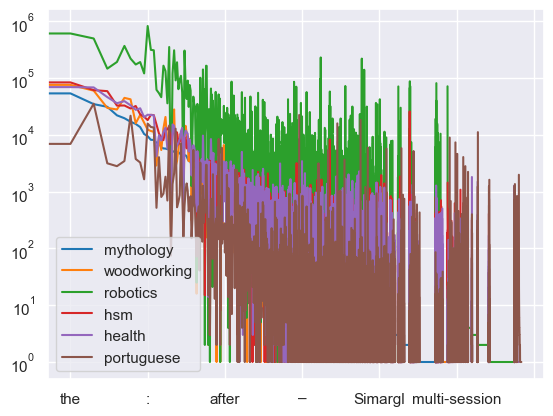

In [62]:
all_token_freqs_df.plot(loglog=True)
plt.show()

#### 🚧 TODO: Do length frequency follow Zipf's law?

The first graph (linear scale) shows a very sharp drop-off. The linear scale makes it difficult to properly evaluate Zipf's law. The visualization isn't ideal for analyzing this type of distribution.

The second graph (log-log scale) is a better visualization for analyzing Zipf's law. It looks like there is an initial plateau at high frequencies, very steep drop-off in the middle and noisy fluctuations in the lower frequencies. It does not show the characteristic straight line of Zipf's law

The third graph (log-log scale with scatter points) shows the same general pattern but with individual data points. It still doesn't look like a Zipf distribution.

#### What could go wrong?

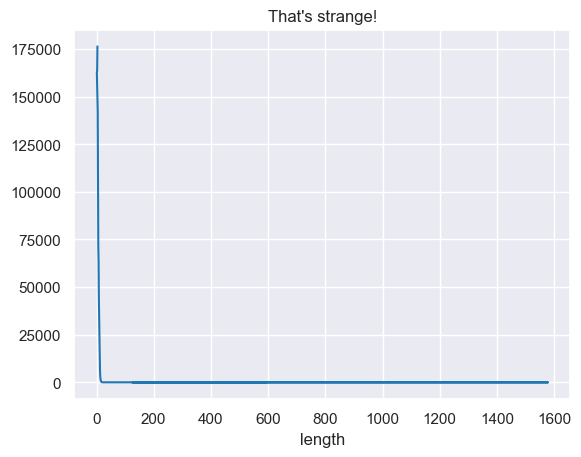

In [51]:
myth_len_freqs.plot(title="That's strange!")
plt.show()

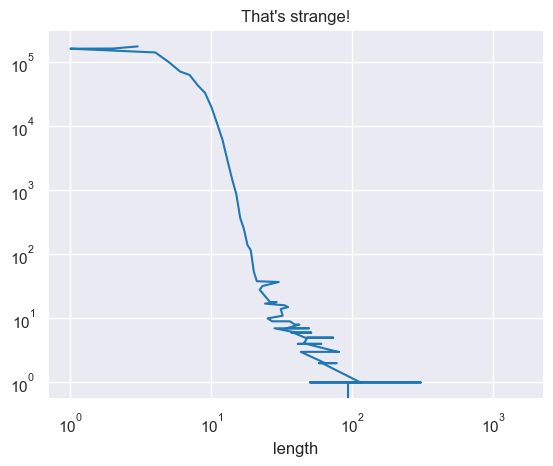

In [52]:
myth_len_freqs.plot(title="That's strange!", loglog=True)
plt.show()

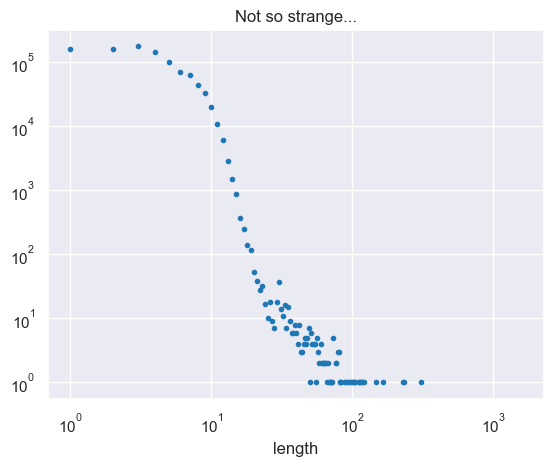

In [53]:
myth_len_freqs.plot(title="Not so strange...", loglog=True, style=".")
plt.show()

* We can remove any zero values before taking the logarithms. Also we can try to properly rank the frequencies in descending order and bin the data if there are too many discrete points. We can also add a reference line showing the Zipf's law so we can compare if the distribution follows it.

#### 🚧 TODO: How to compute richness in words? How to compute the type/token ratio? Who will win this time?

In [54]:
df.head(2)

,files_n,chars_n,text,chars_per_file,char_types_n,char_type_ratio,type_chars_1000,tokens,tokens_n,types_n,avg_wordsize,len_freq,token_type_ratio
corpus,,,,,,,,,,,,,
mythology,1503,4969844,Q:\n\nWhy were the Greek Gods on Olympus?\n\nI...,3306.62,1702,3.42e-04,42,"[Q, :, Why, were, the, Greek, Gods, on, Olympu...",998926,53030,4.98,"{1: 162566, 3: 176327, 4: 141993, 5: 99864, 2:...",0.05
woodworking,2860,7842345,Q:\n\nIs support on three sides of a long popl...,2742.08,173,2.21e-05,45,"[Q, :, Is, support, on, three, sides, of, a, l...",1620394,35469,4.84,"{1: 248312, 2: 267055, 7: 92195, 5: 171534, 4:...",0.02


In [55]:
df["token_type_ratio"] = df.types_n / df.tokens_n
df["token_type_ratio"]

corpus
mythology      0.05
woodworking    0.02
robotics       0.02
hsm            0.04
health         0.04
portuguese     0.06
Name: token_type_ratio, dtype: float64

### What happened to Portuguese?

- Portuguese is an inflectional language! Nouns, adjectives, and, in particular, verbs have many forms.

- Let's try with a type-token ration growth plot to illustrate this.

In [56]:
word_types = df.tokens.progress_map(
    lambda x: batch_counts(x, max_len=df.tokens_n.min(), hop=10_000)
)

  0%|          | 0/6 [00:00<?, ?it/s]

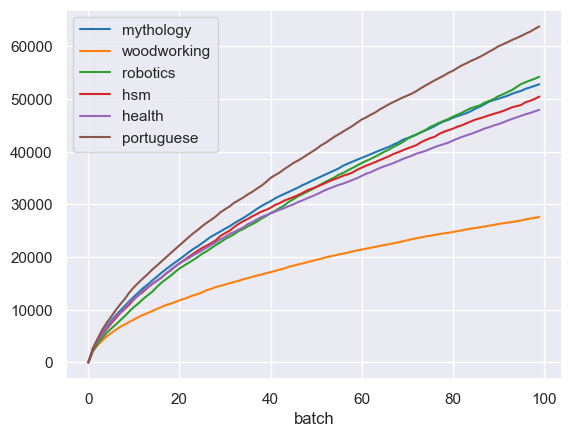

In [57]:
word_type_df = pd.DataFrame(dict(zip(word_types.index, word_types.values)))
word_type_df.index.name = "batch"
word_type_df.plot()
plt.show()

In [58]:
word_type_df

,mythology,woodworking,robotics,hsm,health,portuguese
batch,,,,,,
0,0,0,0,0,0,0
1,2512,2150,2134,2413,2595,2720
2,4184,3270,3465,4074,4126,4464
3,5543,4118,4579,5206,5270,6151
4,6778,4910,5607,6334,6594,7501
...,...,...,...,...,...,...
95,51528,26937,52826,48856,46800,61947
96,51926,27147,53188,49380,47102,62386
97,52198,27296,53517,49657,47341,62776


### Percentage of new words

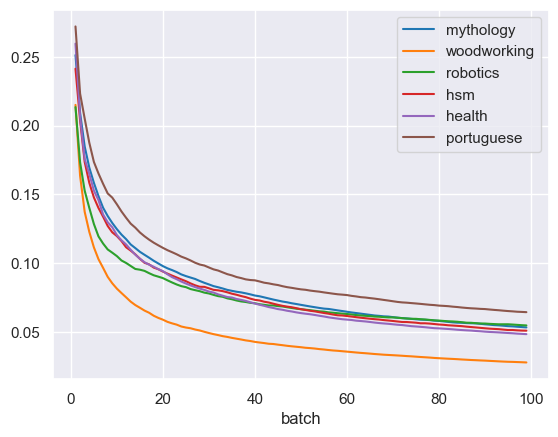

In [59]:
# 🚧 TODO: : Fix the code below (comes from the question nb)

batches = np.arange(0, df.tokens_n.min(), 10_000)
word_type_token_df = word_type_df.divide(batches, axis="index")

word_type_token_df.plot()
plt.show()

In [60]:
word_type_token_df

,mythology,woodworking,robotics,hsm,health,portuguese
batch,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.25,0.21,0.21,0.24,0.26,0.27
2,0.21,0.16,0.17,0.20,0.21,0.22
3,0.18,0.14,0.15,0.17,0.18,0.21
4,0.17,0.12,0.14,0.16,0.16,0.19
...,...,...,...,...,...,...
95,0.05,0.03,0.06,0.05,0.05,0.07
96,0.05,0.03,0.06,0.05,0.05,0.06
97,0.05,0.03,0.06,0.05,0.05,0.06


- Portuguese stays on top!

### 🚧 TODO: 
- resume the 3 most important points that you've learned completing this notebook

1. Character distribution varies significantly by language and domain.

2. Word length distributions follow predictable patterns across different corpora, with most words being 2-8 characters (kind of following Zipf-like distributions).

3. Type-token ratios reveal language characteristics. For example Portuguese has higher ratios due to more word variations, while technical corpora have lower ratios due to repeated specialized vocabulary.

____

# 🌟